# Missing RPE Data

On some of the game dates, we don't have RPE data. But, we are mainly concerned with the acute/chronic ratio which we can compute for the dates for which it is missing.

In [1]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from scipy.stats import ttest_ind, ttest_rel
from scipy.stats import pointbiserialr
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
np.random.seed(5151)
raw_rpe_df = pd.read_csv('./processed_data/processed_rpe.csv')
raw_rpe = raw_rpe_df.copy()[['Date', 'PlayerID', 'RPE']]
print(raw_rpe_df.head())


   Unnamed: 0        Date  PlayerID  Training SessionType  Duration  RPE  \
0           0  2017-08-01        15         1    Strength      60.0  4.0   
1           1  2017-08-01         1         1       Speed      60.0  3.0   
2           2  2017-08-01         1         1    Strength      90.0  4.0   
3           3  2017-08-01         3         1       Speed      45.0  5.0   
4           4  2017-08-01         3         1    Strength      90.0  5.0   

   SessionLoad  DailyLoad  AcuteChronicRatio  ObjectiveRating  FocusRating  \
0        240.0      300.0               4.29              6.0          7.0   
1        180.0      540.0               4.29              0.0          0.0   
2        360.0      540.0               4.29              0.0          0.0   
3        225.0      675.0               4.29              7.0          7.0   
4        450.0      675.0               4.29              7.0          7.0   

   BestOutOfMyself  AcuteLoad  ChronicLoad  
0              3.0      42.86

## Drop Duplicate Dates

This occurs when there are multiple training sessions on the same date. We only care about the daily load so we can drop the duplicate sessions.

In [3]:
rpe_df = raw_rpe_df.copy()[['Date', 'PlayerID', 'DailyLoad', 'AcuteChronicRatio', 'AcuteLoad', 'ChronicLoad']]
subjective_performance_df = raw_rpe_df.copy()[['Date', 'PlayerID', 'ObjectiveRating', 'FocusRating', 'BestOutOfMyself']]
rpe_df.head()

,Date,PlayerID,DailyLoad,AcuteChronicRatio,AcuteLoad,ChronicLoad
0,2017-08-01,15,300.0,4.29,42.86,10.0
1,2017-08-01,1,540.0,4.29,77.14,18.0
2,2017-08-01,1,540.0,4.29,77.14,18.0
3,2017-08-01,3,675.0,4.29,96.43,22.5
4,2017-08-01,3,675.0,4.29,96.43,22.5


In [4]:
subjective_performance_df.head()

,Date,PlayerID,ObjectiveRating,FocusRating,BestOutOfMyself
0,2017-08-01,15,6.0,7.0,3.0
1,2017-08-01,1,0.0,0.0,3.0
2,2017-08-01,1,0.0,0.0,3.0
3,2017-08-01,3,7.0,7.0,3.0
4,2017-08-01,3,7.0,7.0,3.0


In [5]:
rpe_df = rpe_df.drop_duplicates()

In [6]:
rpe_df.head()

,Date,PlayerID,DailyLoad,AcuteChronicRatio,AcuteLoad,ChronicLoad
0,2017-08-01,15,300.0,4.29,42.86,10.0
1,2017-08-01,1,540.0,4.29,77.14,18.0
3,2017-08-01,3,675.0,4.29,96.43,22.5
5,2017-08-01,5,330.0,4.29,47.14,11.0
7,2017-08-01,8,345.0,4.29,49.29,11.5


## Fill In Missing RPE Data

This row should not be in the dataset since it is the first entry for this player and they are not training.

In [7]:
rpe_df = rpe_df[~ rpe_df['AcuteChronicRatio'].isnull()]

In [8]:
rpe_df['Date'] = pd.to_datetime(rpe_df['Date'])

Adding missing dates and player ids to rpe data:

In [9]:
dates = pd.date_range(start=min(rpe_df['Date']), end=max(rpe_df['Date']))
players = rpe_df['PlayerID'].unique()
idx = pd.MultiIndex.from_product((dates, players), names=['Date', 'PlayerID'])

rpe_df = rpe_df.set_index(['Date', 'PlayerID']).reindex(idx, fill_value=0).reset_index().sort_values(by=['Date', 'PlayerID'])



Use a rolling window to compute acute load and chronic load:

In [10]:
temp = rpe_df[['Date','PlayerID','DailyLoad']].drop_duplicates()
past7Days = temp.groupby('PlayerID').rolling('7d', on='Date')['DailyLoad'].sum().reset_index()
past7Days['newAcuteLoad'] = (past7Days['DailyLoad'] / 7.).round(2)
past7Days = past7Days.drop(columns = 'DailyLoad')

rpe_df = pd.merge(rpe_df, past7Days, how='left', on=['Date', 'PlayerID'])

In [11]:
past30Days = temp.groupby('PlayerID').rolling('30d', on='Date')['DailyLoad'].sum().reset_index()
past30Days['newChronicLoad'] = (past30Days['DailyLoad'] / 30.).round(2)
past30Days = past30Days.drop(columns = 'DailyLoad')

rpe_df = pd.merge(rpe_df, past30Days, how="left", on=["Date", "PlayerID"])

In [12]:
rpe_df.drop(['ChronicLoad','AcuteLoad'],axis = 1, inplace = True)
rpe_df.rename(columns = {'newChronicLoad':'ChronicLoad','newAcuteLoad':'AcuteLoad'}, inplace = True)
rpe_df['AcuteChronicRatio'] = (rpe_df['AcuteLoad'] / rpe_df['ChronicLoad']).round(2)

In [13]:
gps_df = pd.read_csv('./processed_data/processed_gps.csv')
gps_df = gps_df.drop(columns=['Unnamed: 0'])
gps_df.head()


,Date,GameID,Outcome,TeamPoints,PlayerID,MaxSpeedInGame,MaxAccelImpulseInGame
0,2017-11-30,1,W,19,2,7.284728,4.423615
1,2017-11-30,1,W,19,3,6.852436,4.888893
2,2017-11-30,1,W,19,4,7.267784,5.694449
3,2017-11-30,1,W,19,6,6.338894,4.777782
4,2017-11-30,1,W,19,7,7.065283,4.091273


In [14]:
# merged_df = gps_df.merge(rpe_df, how='left', on=['Date', 'PlayerID'])
# merged_df.head()
gps_df['Date'] = pd.to_datetime(gps_df['Date'])
train_performance = gps_df.merge(rpe_df[[
    'Date','PlayerID', 'AcuteLoad',
    'ChronicLoad','AcuteChronicRatio']],
    how='left', on= ['Date','PlayerID']).drop_duplicates()
print(len(train_performance))
train_performance.head()

443


,Date,GameID,Outcome,TeamPoints,PlayerID,MaxSpeedInGame,MaxAccelImpulseInGame,AcuteLoad,ChronicLoad,AcuteChronicRatio
0,2017-11-30,1,W,19,2,7.284728,4.423615,206.57,371.20,0.56
1,2017-11-30,1,W,19,3,6.852436,4.888893,407.86,454.67,0.90
2,2017-11-30,1,W,19,4,7.267784,5.694449,236.00,406.90,0.58
3,2017-11-30,1,W,19,6,6.338894,4.777782,297.29,415.87,0.71
4,2017-11-30,1,W,19,7,7.065283,4.091273,237.57,476.60,0.50


In [15]:
wellness_df = pd.read_csv('./processed_data/processed_wellness.csv')
wellness_df = wellness_df.drop(columns=['Unnamed: 0'])
wellness_df['Date'] = pd.to_datetime(wellness_df['Date'])
wellness_df.head()

,Date,PlayerID,MonitoringScore,Fatigue,Soreness,Desire,Irritability,SleepScore,SleepHours,SleepQuality,TrainingReadiness,Pain,Illness,Nutrition,StandardizedMonitoringScore,StandardizedPain,StandardizedIllness,StandardizedNutrition,StandardizedTrainingReadiness,wellness
0,2018-07-21,1,13,3,3,2,3,16.0,8.00,2,0,1,3,3,-1.450204,0.364611,0.331464,0.722090,-1.826823,-1.858861
1,2018-07-21,2,19,4,3,4,4,32.0,8.00,4,0,0,3,3,0.170622,-2.742646,0.331464,0.722090,-1.826823,-3.345293
2,2018-07-21,3,19,3,3,5,4,32.0,8.00,4,100,1,3,3,0.170622,0.364611,0.331464,0.722090,0.795746,2.384534
3,2018-07-21,4,15,2,3,5,4,6.5,6.50,1,95,1,3,3,-0.909929,0.364611,0.331464,0.722090,0.664618,1.172854
4,2018-07-21,5,20,5,3,4,4,29.0,7.25,4,100,1,3,2,0.440759,0.364611,0.331464,-1.220149,0.795746,0.712432


Impute wellness data for missing dates (if we merge without doing this there are 12 instances of performance data that have no wellness data):

In [16]:
wellness_dates = pd.date_range(start=min(train_performance['Date']), end=max(train_performance['Date']))
wellness_players = wellness_df['PlayerID'].unique()
wellness_idx = pd.MultiIndex.from_product((wellness_dates, wellness_players), names=['Date', 'PlayerID'])

wellness_df = wellness_df.set_index(['Date', 'PlayerID']).reindex(wellness_idx).reset_index().sort_values(by=['Date', 'PlayerID'])

wellness_df[wellness_df['MonitoringScore'].isnull()].shape

(779, 20)

In [17]:
print(len(wellness_df))

3978


We see that there are 779 observations where we need to forward fill to impute the wellness data. This is out of 3978 observations after we reindex the data which is 20% of the observations.

In [18]:
wellness_df = wellness_df.fillna(method='ffill')

In [19]:
merged_df = train_performance.merge(wellness_df,
    how='left', on= ['Date','PlayerID']).drop_duplicates()
print(len(merged_df))
merged_df.head()

443


,Date,GameID,Outcome,TeamPoints,PlayerID,MaxSpeedInGame,MaxAccelImpulseInGame,AcuteLoad,ChronicLoad,AcuteChronicRatio,...,TrainingReadiness,Pain,Illness,Nutrition,StandardizedMonitoringScore,StandardizedPain,StandardizedIllness,StandardizedNutrition,StandardizedTrainingReadiness,wellness
0,2017-11-30,1,W,19,2,7.284728,4.423615,206.57,371.20,0.56,...,0.0,1.0,3.0,2.0,0.981035,0.364611,0.331464,-1.220149,-1.826823,-1.369861
1,2017-11-30,1,W,19,3,6.852436,4.888893,407.86,454.67,0.90,...,100.0,1.0,3.0,3.0,1.251172,0.364611,0.331464,0.722090,0.795746,3.465084
2,2017-11-30,1,W,19,4,7.267784,5.694449,236.00,406.90,0.58,...,100.0,1.0,3.0,3.0,0.710897,0.364611,0.331464,0.722090,0.795746,2.924809
3,2017-11-30,1,W,19,6,6.338894,4.777782,297.29,415.87,0.71,...,90.0,1.0,3.0,3.0,0.440759,0.364611,0.331464,0.722090,0.533489,2.392414
4,2017-11-30,1,W,19,7,7.065283,4.091273,237.57,476.60,0.50,...,95.0,1.0,3.0,3.0,1.251172,0.364611,0.331464,0.722090,0.664618,3.333956


In [20]:
print(merged_df[merged_df['MonitoringScore'].isnull()])

Empty DataFrame
Columns: [Date, GameID, Outcome, TeamPoints, PlayerID, MaxSpeedInGame, MaxAccelImpulseInGame, AcuteLoad, ChronicLoad, AcuteChronicRatio, MonitoringScore, Fatigue, Soreness, Desire, Irritability, SleepScore, SleepHours, SleepQuality, TrainingReadiness, Pain, Illness, Nutrition, StandardizedMonitoringScore, StandardizedPain, StandardizedIllness, StandardizedNutrition, StandardizedTrainingReadiness, wellness]
Index: []

[0 rows x 28 columns]


## Explore Performance Data

Before modeling performance data, we need to make sure there are no outliers in the data. The performance data is computed from data gathered by sensors so any issue with sensors will present itself as outliers in our data.

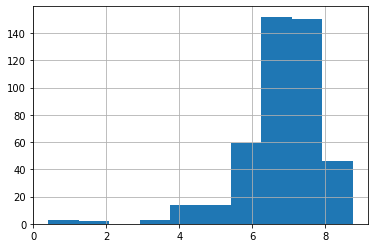

In [21]:
merged_df['MaxSpeedInGame'].hist()

In [22]:
merged_df.to_csv('./processed_data/merged_df.csv')

In [23]:
merged_df = merged_df[(merged_df['MaxSpeedInGame'] >= 5) & (merged_df['MaxSpeedInGame'] <= 9)]

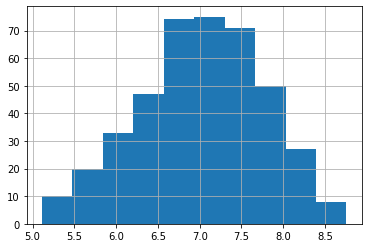

In [24]:
merged_df['MaxSpeedInGame'].hist()

## Correlations Between Predictors and Response

Based on our previous analysis, we think that `AcuteChronicRatio`, `MonitoringScore`, `Pain`, `Illness`, `Nutrition` will be predictors for `MaxSpeedInGame` which is our measure for performance. We also have an overall score for wellness called `wellness` which is the combination of all predictors other than `AcuteChronicRatio`.

In [25]:
def scatter_plot(df, x, y, title=None):
    df.plot.scatter(x, y)
    if title:
        plt.title(title)
    plt.show()

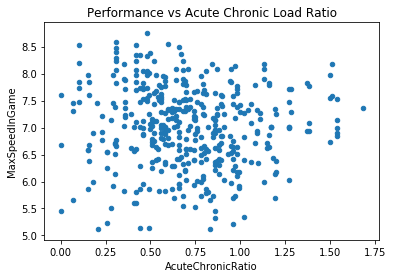

In [26]:
scatter_plot(merged_df, 'AcuteChronicRatio', 'MaxSpeedInGame', 'Performance vs Acute Chronic Load Ratio')


It does not look like there is any clear pattern between load and performance.

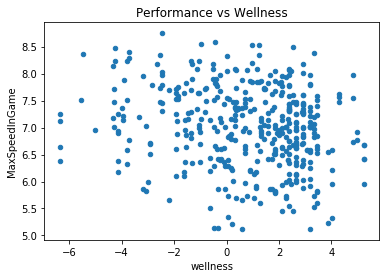

In [27]:
scatter_plot(merged_df, 'wellness', 'MaxSpeedInGame', 'Performance vs Wellness')


In [28]:
merged_df['wellness'].corr(merged_df['MaxSpeedInGame'])

-0.19368274836264404

In [29]:
grouped_merged_df = merged_df[['wellness', 'MaxSpeedInGame', 'PlayerID']].groupby('PlayerID').mean()
grouped_merged_df

,wellness,MaxSpeedInGame
PlayerID,,
1,-0.714285,7.683961
2,-2.491324,6.902797
3,2.722862,7.230131
4,1.706906,6.799333
5,-0.074293,7.721914
6,1.667970,6.511335
7,1.219980,7.383135
8,1.461009,7.159093
9,0.103829,6.931128


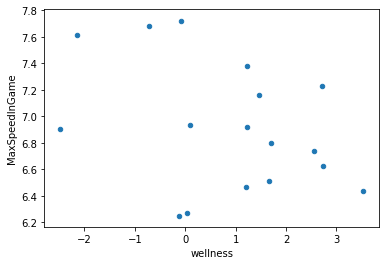

In [30]:
scatter_plot(grouped_merged_df, 'wellness', 'MaxSpeedInGame')

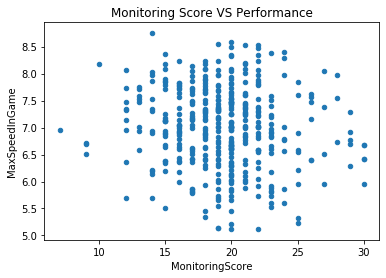

In [31]:
scatter_plot(merged_df, 'MonitoringScore', 'MaxSpeedInGame', 'Monitoring Score VS Performance')


In [32]:
merged_df['MonitoringScore'].corr(merged_df['MaxSpeedInGame'])

-0.1101398501612068

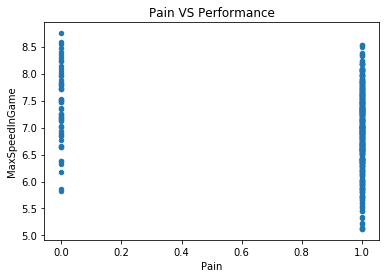

In [33]:
scatter_plot(merged_df, 'Pain', 'MaxSpeedInGame', 'Pain VS Performance')

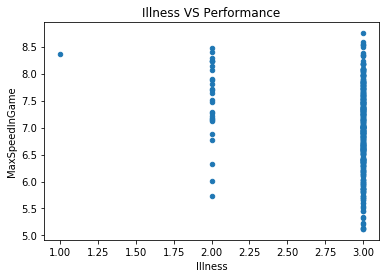

In [34]:
scatter_plot(merged_df, 'Illness', 'MaxSpeedInGame', 'Illness VS Performance')

In [35]:
ttest_ind(merged_df[merged_df['Illness'] == 2]['MaxSpeedInGame'], merged_df[merged_df['Illness'] == 3]['MaxSpeedInGame'])

Ttest_indResult(statistic=3.6342015507440735, pvalue=0.00031409377499258713)

We get a significant results that the performance of those saying they are slightly off is better than those who are not ill.

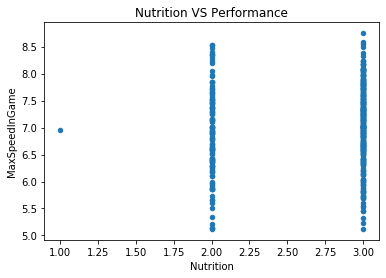

In [36]:
scatter_plot(merged_df, 'Nutrition', 'MaxSpeedInGame', 'Nutrition VS Performance')

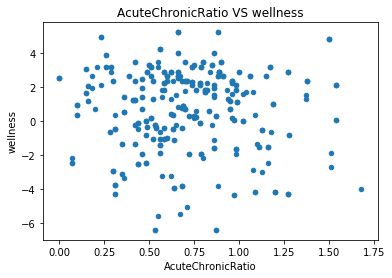

In [37]:
scatter_plot(merged_df, 'AcuteChronicRatio', 'wellness', 'AcuteChronicRatio VS wellness')

We see that there are no clear patterns when we are looking at the repeated measures data. Maybe we will get something out of using a mixed models regression.

### Regressions Of Wellness and Load on Performance

In [38]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import aic
from statsmodels.graphics.gofplots import qqplot

#### Mixel Linear Models

We want to first model the relationship between Load and Wellness vs performance using a mixed linear model. This is because our data includes repreated measurements for each player over many games. In this case, the random effect will be the player id such that we group the measurements by player. We will be using random intercepts but not random slopes. This means we allow each player to have a random intercept, or random base level of performance, but each player should share the same slopes for each predictor. In this way, we allow the model to adjust to the base performance level of each player but we find relationships between the predicors and the response that are generalizable across the entire team.

In [39]:
merged_df['SquaredAcuteChronicRatio'] = merged_df['AcuteChronicRatio'] ** 2
merged_df['CubedAcuteChronicRatio'] = merged_df['AcuteChronicRatio'] ** 3

In [40]:
mixed_mod = smf.mixedlm("MaxSpeedInGame ~ AcuteChronicRatio + SquaredAcuteChronicRatio + MonitoringScore + SleepHours + TrainingReadiness + Pain + Illness + Nutrition", merged_df, groups=merged_df['PlayerID'])
mixed_res = mixed_mod.fit()
print(mixed_res.summary())

               Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   MaxSpeedInGame
No. Observations:    415       Method:               REML          
No. Groups:          17        Scale:                0.3796        
Min. group size:     4         Likelihood:           -421.3586     
Max. group size:     38        Converged:            Yes           
Mean group size:     24.4                                          
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 7.528    0.627 12.008 0.000  6.299  8.756
AcuteChronicRatio        -0.356    0.393 -0.907 0.365 -1.126  0.414
SquaredAcuteChronicRatio  0.146    0.242  0.602 0.547 -0.329  0.621
MonitoringScore          -0.014    0.010 -1.378 0.168 -0.034  0.006
SleepHours                0.017    0.037  0.453 0.650 -0.056  0

In [41]:
aic1 = aic(mixed_res.llf, 415, 9)
aic1


860.7171952840849

We can use this AIC measure as a baseline for comparing this model to the models below. Given that p-values for mixed linear models aee unreliable, we will use AIC as our metric for model selection. We want to removed uninformative features such that it makes the AIC of the model lower. In doing so, we hope to find a model that gives us some insights into the relationship between a subset of these predictors and the performance of players.

We see that even though we are modeling the realationship between load and perfromance non-linearly, we see that the 95% confidence interval for the load terms contains positive and negative values including 0. Furthermore, the standard error of the estimates for the coefficients are similar in magnitude to the estimates themselves, meaning the true value could be far from the estimate given. Thus, we cannot make any conclusions about relationship between performance and load given this model. This is not what we expected but makes sense based on our data as we found no clear patterns in the relationship between load and performance in the scatter plots above. Thus, we should remove the load terms from the model and see if we can find any stronger relationships for some of the wellness predictors.

We are tempted to expand the monitoring score into the predictors that make it up, but as we say in the wellness exploratory notebook, these predictors are all correlated with eachother, so they cannot be predictors in a model.

Thus, we will remove the load values and see what the resulting model looks like.

In [42]:
mixed_mod = smf.mixedlm("MaxSpeedInGame ~ MonitoringScore + SleepHours + TrainingReadiness + Pain + Illness + Nutrition ", merged_df, groups=merged_df['PlayerID'])
mixed_res = mixed_mod.fit()
print(mixed_res.summary())


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: MaxSpeedInGame
No. Observations: 415     Method:             REML          
No. Groups:       17      Scale:              0.3788        
Min. group size:  4       Likelihood:         -420.4366     
Max. group size:  38      Converged:          Yes           
Mean group size:  24.4                                      
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          7.309    0.598 12.213 0.000  6.136  8.482
MonitoringScore   -0.014    0.010 -1.404 0.160 -0.034  0.006
SleepHours         0.018    0.037  0.475 0.635 -0.056  0.091
TrainingReadiness -0.001    0.002 -0.387 0.699 -0.005  0.004
Pain              -0.179    0.109 -1.645 0.100 -0.393  0.034
Illness           -0.136    0.139 -0.981 0.327 -0.408  0.136
Nutrition          0.148    0.091  1

In [43]:
aic2 = aic(mixed_res.llf, 415, 7)
aic2

854.8731175362045

In [44]:
np.exp((min([aic1, aic2]) - max([aic1, aic2])) / 2)

0.05382383533602819

The AIC for this model is less than that of the first model, suggesting that this model loses less information from the process that generated the data compared to the first model, which is to say it is a better model of the data. In fact, the first model is only about `0.135` time as likely to minimize the information lost as the second model. Furthermore, it appears that sleep hours and training readiness do not have an effect on performance given their point estimates are close to 0 and their standard errors are small compared to the scale of the response. Thus we can remove these predictors from the model.

In [45]:
mixed_mod = smf.mixedlm("MaxSpeedInGame ~ MonitoringScore + Pain + Illness + Nutrition ", merged_df, groups=merged_df['PlayerID'])
mixed_res = mixed_mod.fit()
print(mixed_res.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: MaxSpeedInGame
No. Observations: 415     Method:             REML          
No. Groups:       17      Scale:              0.3772        
Min. group size:  4       Likelihood:         -413.0785     
Max. group size:  38      Converged:          Yes           
Mean group size:  24.4                                      
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          7.394    0.515 14.353 0.000  6.384  8.403
MonitoringScore   -0.013    0.009 -1.419 0.156 -0.032  0.005
Pain              -0.178    0.107 -1.663 0.096 -0.388  0.032
Illness           -0.143    0.138 -1.035 0.301 -0.413  0.128
Nutrition          0.145    0.091  1.592 0.111 -0.033  0.323
Group Var          0.169    0.113                           



In [46]:
aic3 = aic(mixed_res.llf, 415, 5)
aic3


836.1570952840652

In [47]:
np.exp((aic3 - aic2) / 2)

8.627151136064475e-05

We see that after removing, sleep hours and training readiness, we get another model with an even lower AIC. Compared to this new model, the second model is only about `0.135` times as likely to lose less information. Looking at the coefficient estimate for the monitoring score, we see that its point estimate is close to 0 and it's standard error is small, which means it is likely to be 0 or that the effect size of the relationship to perforamnce is very small. Thus, we could remove monitoring score from the model.

In [48]:
mixed_mod = smf.mixedlm("MaxSpeedInGame ~ C(Pain) + Illness + Nutrition", merged_df, groups=merged_df['PlayerID'])
mixed_res = mixed_mod.fit()
print(mixed_res.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: MaxSpeedInGame
No. Observations: 415     Method:             REML          
No. Groups:       17      Scale:              0.3780        
Min. group size:  4       Likelihood:         -410.3327     
Max. group size:  38      Converged:          Yes           
Mean group size:  24.4                                      
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          7.143    0.485 14.736 0.000  6.193  8.093
C(Pain)[T.1.0]    -0.203    0.106 -1.920 0.055 -0.410  0.004
Illness           -0.135    0.138 -0.978 0.328 -0.406  0.136
Nutrition          0.141    0.091  1.551 0.121 -0.037  0.320
Group Var          0.172    0.115                           



In [49]:
aic4 = aic(mixed_res.llf, 415, 4)
aic4

828.6654056240745

In [50]:
np.exp((aic4 - aic3) / 2)

0.023615669391745208

We see that after removing the monitoring score, our model's AIC drops slightly. In fact, the previous model with the monitoring score is `0.368` times as likly to to minimize the information loss compared to this model. Thus, we can conlude this new model is the best fit to the data we have trained so far.

The point estimate for illness is about the same magnitude as the standard error so we cannot make any conclusions about its effect. It is entirely possible that this coefficient is actually 0 instead of negative. Thus, we could improve the model by removing it.

In [51]:
mixed_mod = smf.mixedlm("MaxSpeedInGame ~ C(Pain) + Nutrition", merged_df, groups=merged_df['PlayerID'])
mixed_res = mixed_mod.fit()
print(mixed_res.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: MaxSpeedInGame
No. Observations: 415     Method:             REML          
No. Groups:       17      Scale:              0.3773        
Min. group size:  4       Likelihood:         -409.7422     
Max. group size:  38      Converged:          Yes           
Mean group size:  24.4                                      
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          6.749    0.271 24.933 0.000  6.219  7.280
C(Pain)[T.1.0]    -0.205    0.106 -1.941 0.052 -0.413  0.002
Nutrition          0.141    0.091  1.545 0.122 -0.038  0.320
Group Var          0.180    0.119                           



In [52]:
aic5 = aic(mixed_res.llf, 415, 3)
aic5

825.4844518902278

In [53]:
np.exp((aic5 - aic4) / 2)

0.20382838953801416

We see that removing illness from the model improves the AIC value. However, the improvement is the smallest yet as the 4th model is about `0.2` times as likely to actually minimize the information lost as the 5th model. Since the 5th model has the lowest AIC, we can say it is the best model for the data and thus, we can use it to interpret the relationship between performance and our significant measures of wellness: pain and nutrition.

It seems like this model is a good fit to the data. To verify this, we can fit another kind of model that accepted repreated measures called a generalized estimating equation (GEE) model. GEE models require that we provide the structure of the covariance between groups. We will use the Exchangeable covariance structure which assumes the measurements in a given group are correlated in the same way. In our case, that is to say the measurements for each player are correlated in the same way which makes sense. In fact, GEE with exchangeable correlation structure is annalogus to a mixed model with random intercepts, however, GEE uses a different algorithm to estimate the value of the parameters. Some research indicates that GEE is actually better than mixed models, for example, in [this paper](https://www.ncbi.nlm.nih.gov/pubmed/20220526), Hubbard et. al. aruge that: "in general that mixed models involve unverifiable assumptions on the data-generating distribution, which lead to potentially misleading estimates and biased inference. We conclude that the estimation-equation approach of population average models provides a more useful approximation of the truth." Thus, if we find that the GEE model has similar coefficient estimates to the mixed model, this adds evidence that those coefficients are representative of the actual relationships in the data.

In [54]:
fam = sm.families.Gaussian()
ind = sm.cov_struct.Exchangeable()
mod = smf.gee("MaxSpeedInGame ~ C(Pain) + Nutrition", "PlayerID", merged_df, cov_struct=ind, family=fam)
res = mod.fit()
print(res.summary())

                               GEE Regression Results                              
Dep. Variable:              MaxSpeedInGame   No. Observations:                  415
Model:                                 GEE   No. clusters:                       17
Method:                        Generalized   Min. cluster size:                   4
                      Estimating Equations   Max. cluster size:                  38
Family:                           Gaussian   Mean cluster size:                24.4
Dependence structure:         Exchangeable   Num. iterations:                     7
Date:                     Mon, 09 Dec 2019   Scale:                           0.538
Covariance type:                    robust   Time:                         17:21:15
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.7511      0.253     26.728      0.000       6.256       7

We see that the coefficients of the GEE model are in fact similar to those of the mixed model.

#### Test Model Fit

Before interpreting the coefficients, we should check our assumption that the model is a good fit to the data. We can do this by first doing a QQ plot to ensure that the residuals of the model are uniformly distributed.

##### Mixed Model

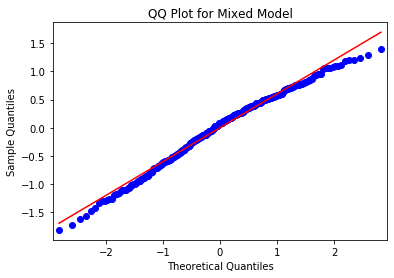

In [55]:
qqplot(mixed_res.resid, line='s')
plt.title('QQ Plot for Mixed Model')
plt.show()

##### GEE Model

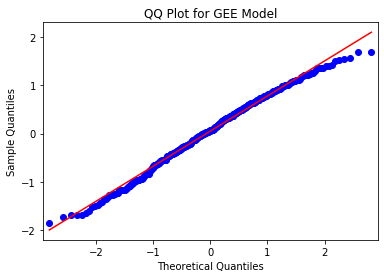

In [56]:
qqplot(res.resid, line='s')
plt.title('QQ Plot for GEE Model')
plt.show()

We see that, for the most part, the QQ plot is a straight line which means the residuals are normally distributed. For both models, there is a slight deviations from the line for large positive residuals, wherein the GEE model is closer to normally distributed than the mixed model. However, this deviation is minute and both models have similar coefficients so we conlcude that they are both good fits to the data and we can interpret the coefficients of either model to infer the relationship between the predictors and the response.

We can also plot the residuals versus the predictors to ensure that there are no patterns in the residuals with respect to any of the predictors.

#### Coefficient Interpretation

Before interpreting the coefficients, we should review the variance of performance data so we can contextualize the effect sizes of the relationships between the effects and the responses.

In [57]:
merged_df['MaxSpeedInGame'].std()

0.7460984551489096

We see that the standard deviation of the performance metric is about `0.75`.

Looking at the coefficients of our model above, we see moderatly strong evidence that Pain has a negative relationship to performance. The standard error of this estimate is about half of the point estimate itself. Recalling how we coded pain, this is interesting because pain equal to 1 refers to not being in pain. Thus, better wellness with respect to pain is leading to worse performance.

For example, from: https://healthsci.mcmaster.ca/docs/librariesprovider8/research/methodology/study-design-and-methodological-issues/statistical-analysis-of-correlated-data-using-generalized-estimating-equations--an-orientation.pdf?sfvrsn=4b1c0d3b_4 , GEE uses a quasi-liklihood approach and uses weighted combinations of observations to extract theappropriate amount of information from correlated data. If we get similar conclusions from this alternative measure of analysing correlated data, it will add more support to our conclusions.

In [58]:
fam = sm.families.Gaussian()
ind = sm.cov_struct.Exchangeable()
mod = smf.gee("MaxSpeedInGame ~ Pain + Illness + Nutrition", "PlayerID", merged_df, cov_struct=ind, family=fam)
res = mod.fit()
print(res.summary())

                               GEE Regression Results                              
Dep. Variable:              MaxSpeedInGame   No. Observations:                  415
Model:                                 GEE   No. clusters:                       17
Method:                        Generalized   Min. cluster size:                   4
                      Estimating Equations   Max. cluster size:                  38
Family:                           Gaussian   Mean cluster size:                24.4
Dependence structure:         Exchangeable   Num. iterations:                     8
Date:                     Mon, 09 Dec 2019   Scale:                           0.531
Covariance type:                    robust   Time:                         17:21:15
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.1829      0.491     14.632      0.000       6.221       8.145
Pain   

Removing Load terms as they do not seem to affect performance in this data set.

We see that in general, the relationship between hours of sleep, quality of sleep, and soreness is very similar in this GEE model as our linear model. Unfortunatly, we cannot compute AIC values for a GEE model but the fact that this model makes the same conclusions as the mixed linear model does about these predictors adds more validty to them. On the other hand, this model gives support to a stronger conclusion about illness. It seems to suggest that having a lower illness score, meaning more ill in our case, leads to stronger performance. This will be explored further as we plot the residuals.

#### Residual and QQ Plots

To ensure that these models are good fits to the data, we should ensure that there are no patterns in the residual plots and that the QQ plots are generally straight lines. This would mean that our model is not over or underpredicting the performance given the value of a predictor and we do not need to add any more terms to our model to fit the data better.

In [59]:
#gee_predictions = mod.predict(merged_df[['AcuteChronicRatio', 'SquaredAcuteChronicRatio', 'MonitoringScore', 'TrainingReadiness', 'Illness', 'Pain', 'Nutrition']])
# TODO: Can get the residuals using res.resid
residual_df = merged_df.copy()[['AcuteChronicRatio', 'MonitoringScore', 'TrainingReadiness', 'Illness', 'Pain', 'Nutrition', 'MaxSpeedInGame']]
residual_df['Residual'] = res.resid
residual_df.head()


,AcuteChronicRatio,MonitoringScore,TrainingReadiness,Illness,Pain,Nutrition,MaxSpeedInGame,Residual
0,0.56,22.0,0.0,3.0,1.0,2.0,7.284728,0.467318
1,0.90,23.0,100.0,3.0,1.0,3.0,6.852436,-0.110429
2,0.58,21.0,100.0,3.0,1.0,3.0,7.267784,0.304919
3,0.71,20.0,90.0,3.0,1.0,3.0,6.338894,-0.623971
4,0.50,23.0,95.0,3.0,1.0,3.0,7.065283,0.102419


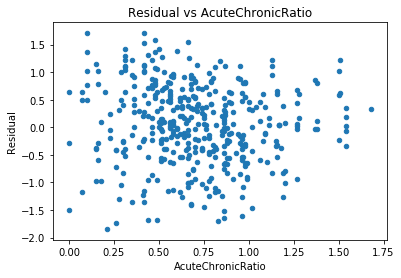

In [60]:
scatter_plot(residual_df, 'AcuteChronicRatio', 'Residual', 'Residual vs AcuteChronicRatio')

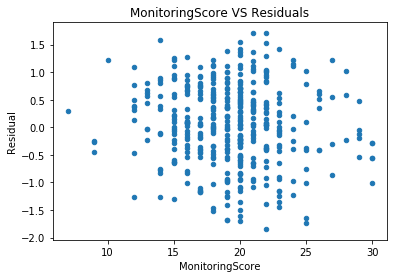

In [61]:
scatter_plot(residual_df, 'MonitoringScore', 'Residual', 'MonitoringScore VS Residuals')

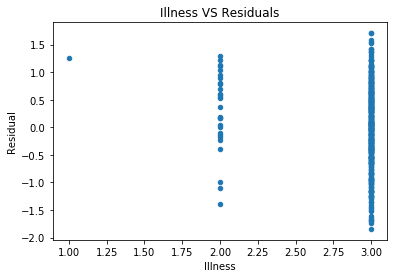

In [62]:
scatter_plot(residual_df, 'Illness', 'Residual', 'Illness VS Residuals')

In [63]:
ttest_ind(residual_df[residual_df['Illness'] == 2]['Residuals'], residual_df[residual_df['Illness'] == 3]['Residuals'])

KeyError: 'Residuals'

No significant difference in the residuals for Illness = 2 or Illness = 3

Recall that our models suggested that lower illness improved perforamnce. Recall that we coded illness such that bring ill is represented by 1, being slightly off is represented by 2, and not being ill is represented by 3. We only have one case of a player being ill and playing which we can ignore. On the other hand, we have some examples of players playing while being slightly off, but not as many as the number of observations where players played when not ill at all.

We should look at those observations where players played while reporting that they were slightly off.

In [ ]:
averaged_df = merged_df.copy()[['PlayerID', 'MaxSpeedInGame', 'Illness']].groupby('PlayerID').mean()
averaged_df

We see that most players always said they were not ill at all on game day with a few exceptions. However, player 10 is the only player with an average illness sufficiently far from 3, meaning they are the only player who would often mark them selves as slightly off. Interestingly, player 10 has one of the highest average performance measures of all players, which is why there appears to be some relationship between feeling more ill and performing better. It is possible that player 10 was more likely than other players to mark themselve as feeling slightly off. It is also possible that player 10's performance was not effected by them feeling off, and this lead to them playing when they were feeling off as opposed to other players that would not have played when they felt off.

This example highlights the selection bias in our dataset. There were some choices that went into which players played a given game so we cannot see the true effect of load and wellness on performance. In other words, we might not see performance issues due to poor wellness because we do not have performance data for istances where wellness was low, since a player with low wellness might not be played. Had we done an controlled experienment where we vary different factors of load and wellness and measure subsequent perforamnce, we might be able to find stronger relationships between load, wellness, and performance.

In [ ]:
scatter_plot(residual_df, 'Pain', 'Residuals', 'Pain VS Residuals')

In [ ]:
ttest_ind(residual_df[residual_df['Pain'] == 0]['Residuals'], residual_df[residual_df['Pain'] == 1]['Residuals'])

No significant difference between mean residuals for pain = 0 or pain = 1

In [ ]:
scatter_plot(residual_df, 'Nutrition', 'Residuals', 'Nutrition VS Residuals')

In [ ]:
ttest_ind(residual_df[residual_df['Nutrition'] == 2]['Residuals'], residual_df[residual_df['Nutrition'] == 3]['Residuals'])

No significant difference between mean residuals for Nutrition = 2 or Nutrition = 3. We ignore Nutrition = 1 because there was only one instance of this in the training set.

## Effect of Wellness On RPE

Now that we have explore the relationships between load and wellness on performance, we want to explore the relationship between wellness and load independent of performance.

In [ ]:
raw_rpe['Date'] = pd.to_datetime(raw_rpe['Date'])
rpe_wellness = wellness_df.merge(raw_rpe, on=['Date', 'PlayerID'])
rpe_wellness.head()

In [ ]:
fam = sm.families.Gaussian()
ind = sm.cov_struct.Exchangeable()

rpe_wellness = rpe_wellness.dropna()
rpe_wellness_mixed = smf.gee("RPE ~ wellness", "PlayerID", rpe_wellness, cov_struct=ind, family=fam)
rpe_wellness_mixed_fit = rpe_wellness_mixed.fit()
print(rpe_wellness_mixed_fit.summary())


In [ ]:
model_rpe_wellness = rpe_wellness.dropna()
#model_rpe_wellness[['RPE']] = StandardScaler().fit_transform(model_rpe_wellness[['RPE']])

rpe_wellness_mixed = smf.gee("RPE ~ MonitoringScore + TrainingReadiness + Pain + Illness + Nutrition", "PlayerID", model_rpe_wellness, cov_struct=ind, family=fam)
rpe_wellness_mixed_fit = rpe_wellness_mixed.fit()
print(rpe_wellness_mixed_fit.summary())


In [ ]:
pre_wellness_predictions = rpe_wellness_mixed_fit.predict()
residual_df = model_rpe_wellness.copy()[['MonitoringScore', 'TrainingReadiness', 'Illness', 'Pain', 'Nutrition', 'RPE']]
residual_df['Prediction'] = pre_wellness_predictions
residual_df['Residuals'] = residual_df['RPE'] - residual_df['Prediction']
residual_df.head()


In [ ]:
scatter_plot(residual_df, 'MonitoringScore', 'Residuals', 'Residuals VS Monitoring Score')

In [ ]:
rpe_wellness['RPE'].corr(rpe_wellness['wellness'])


In [ ]:
grouped_rpe_wellness = rpe_wellness[['PlayerID', 'wellness', 'RPE']].groupby(['PlayerID']).mean()
grouped_rpe_wellness

In [ ]:
grouped_rpe_wellness.corr()

In [ ]:
grouped_rpe_wellness.plot.scatter('wellness', 'RPE')

There is no general trend in average wellness and RPE

## Wellness vs Subjective Performance

In [ ]:
subjective_performance_df.head()

Remember, Best Out Of Myself was lives on a scale of 0, 1, or 3 scale so we should standardize all the values so they can be combined into one measure of subjective performance.

In [ ]:
subjective_performance_scaler = StandardScaler()
standardized_subjective_performance_values = subjective_performance_scaler.fit_transform(subjective_performance_df[['ObjectiveRating', 'FocusRating', 'BestOutOfMyself']])
subjective_performance_df['StandardizedObjectiveRating'] = standardized_subjective_performance_values[:, 0]
subjective_performance_df['StandardizedFocusRating'] = standardized_subjective_performance_values[:, 1]
subjective_performance_df['StandardizedBestOutOfMyself'] = standardized_subjective_performance_values[:, 2]
subjective_performance_df['SubjectivePerformance'] = subjective_performance_df['StandardizedObjectiveRating'] + subjective_performance_df['StandardizedFocusRating'] + subjective_performance_df['StandardizedBestOutOfMyself']
subjective_performance_df.head()


In [ ]:
wellness_df.head()

In [ ]:
subjective_performance_df['Date'] = pd.to_datetime(subjective_performance_df['Date'])
wellness_subjective_performance = wellness_df.merge(subjective_performance_df, how='inner', on= ['Date','PlayerID'])
wellness_subjective_performance.head()


In [ ]:
scatter_plot(wellness_subjective_performance, 'wellness', 'SubjectivePerformance', 'SubjectivePerformance VS wellness')


In [ ]:
averaged_subjective_perofrmance = wellness_subjective_performance[['PlayerID', 'wellness', 'SubjectivePerformance']].groupby('PlayerID').mean()
averaged_subjective_perofrmance


In [ ]:
scatter_plot(averaged_subjective_perofrmance, 'wellness', 'SubjectivePerformance', 'SubjectivePerformance VS wellness')


### Plot Subjective Performance Over Time For Each Player

In [ ]:
for player_id in wellness_subjective_performance['PlayerID'].unique():
    player_df = wellness_subjective_performance[wellness_subjective_performance['PlayerID'] == player_id]
    plt.plot(player_df['Date'], player_df['wellness'])
    plt.title('Wellness over time for player {}'.format(player_id))
    plt.show()
    plt.plot(player_df['Date'], player_df['SubjectivePerformance'])
    plt.title('SubjectivePerformance over time for player {}'.format(player_id))
    plt.show()


## Looking Deeper Into Pain and Illness

When we look at Pain, Illness, and Nutrition vs performance, it almost looks like the average performance for being in pain is less than not being in pain which is counter intuitive. The same goes for nutrition. We should formalize these findings by doing a t-test.

In [ ]:
#averaged_df = merged_df.copy()[['PlayerID', 'MaxSpeedInGame', 'Pain', 'Illness', 'Nutrition', 'AcuteChronicRatio', 'AcuteLoad', 'ChronicLoad', 'wellness', 'MonitoringScore', 'TrainingReadiness']].groupby('PlayerID').mean()
#averaged_df


In [ ]:
#averaged_df.corr()

Remember that taking the correlation of averaged values for repreated measures might not be the best thing to do, (find citation for this - Joe)

### Pain

There were 10 players that were never in pain (ie average pain = 1) so lets compare those players against those that were in pain.

In [ ]:
#not_in_pain = averaged_df[averaged_df['Pain'] == 1]
#not_in_pain['MaxSpeedInGame'].mean()

In [ ]:
#in_pain = averaged_df[averaged_df['Pain'] != 1]
#in_pain['MaxSpeedInGame'].mean()

It seems like those why were not in pain had lower average performance than those who were not in pain which seems counter intuitive. Let's first see if this difference was significant.

In [ ]:
#ttest_ind(not_in_pain['MaxSpeedInGame'], in_pain['MaxSpeedInGame'])

This is a significant result. There must be something more to this relationship.

#### No Pain Players

In [ ]:
#not_in_pain.index

In [ ]:
#averaged_df.loc[not_in_pain.index][[]]

#### Pain Players

In [ ]:
#in_pain.index

## Performance For High And Low Wellness Occurances

It seems like there is not relationship between wellness in general and performance based on the analysis above. To ensure that this is true, we can reframe the question about the relationship by grouping our data into instances of high and low performance, defined by those above or below the median wellness. We can then see if there is a 

In [ ]:
# Need to average over all the players so we have independent measurements
averaged_wellness_df = merged_df.copy()[['PlayerID', 'MaxSpeedInGame', 'wellness']].groupby('PlayerID').mean()
wellness_median = averaged_wellness_df['wellness'].median()

low_wellness_df = merged_df[merged_df['wellness'] < wellness_median]
high_wellness_df = merged_df[merged_df['wellness'] > wellness_median]

ttest_ind(low_wellness_df['MaxSpeedInGame'], high_wellness_df['MaxSpeedInGame'])

As expected, we see that there is no significant difference between average performance of high and low wellness players.

In [ ]:
# Try with monitoring score
averaged_wellness_df = merged_df.copy()[['PlayerID', 'MaxSpeedInGame', 'MonitoringScore']].groupby('PlayerID').mean()
wellness_median = averaged_wellness_df['MonitoringScore'].median()

low_monitoring_score_df = merged_df[merged_df['MonitoringScore'] < wellness_median]
high_monitoring_score_df = merged_df[merged_df['MonitoringScore'] > wellness_median]

ttest_ind(low_monitoring_score_df['MaxSpeedInGame'], high_monitoring_score_df['MaxSpeedInGame'])


Again, we see no significant difference in the performance of those with high and low wellness scores

This adds further evidence to our conclusions that wellness alone does not have a relationship with performance

## Conslusions

Mention final conclusions for the coach based on this data.